In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-prediction-using-logistic-regression/framingham.csv


### IMPORTS

In [2]:
import pandas as pd
import numpy as np
import math,copy
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("/kaggle/input/heart-disease-prediction-using-logistic-regression/framingham.csv")
data.shape

(4238, 16)

### DATA CLEANING

In [4]:
data.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

***CIGARS PER DAY***

Text(0, 0.5, 'Count')

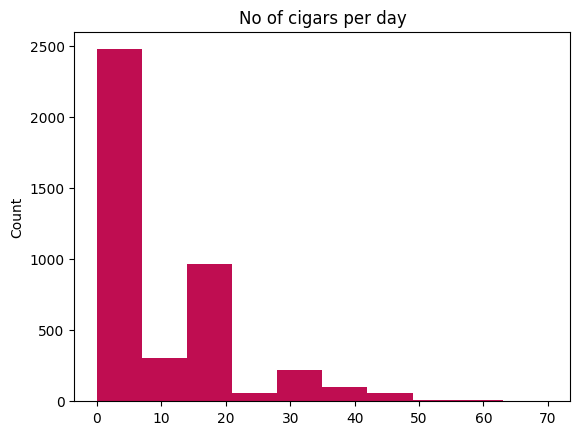

In [5]:
plt.hist(data.cigsPerDay,density=False,color=plt.cm.PuRd(200))
plt.title("No of cigars per day")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

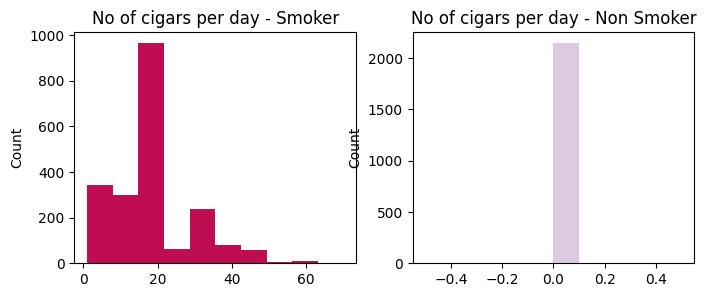

In [6]:
fig,axs = plt.subplots(1,2,figsize=(8,3))
axs[0].hist(data[data.currentSmoker==1].cigsPerDay,density=False,color=plt.cm.PuRd(200))
axs[0].set_title("No of cigars per day - Smoker")
axs[0].set_ylabel("Count")
axs[1].hist(data[data.currentSmoker==0].cigsPerDay,density=False,color=plt.cm.PuRd(50))
axs[1].set_title("No of cigars per day - Non Smoker")
axs[1].set_ylabel("Count")

In [7]:
# Handling missing values in "cigars per day"
# if the person is a current smoker, cigar per day = average cigar per day 
# if the person is a non current smoker, cigar per day = 0

print(data.cigsPerDay.isnull().groupby(by=data.currentSmoker).sum())

currentSmoker
0     0
1    29
Name: cigsPerDay, dtype: int64


In [8]:
data.loc[data.cigsPerDay.isnull(),["cigsPerDay"]] = round(data[data.currentSmoker==1].cigsPerDay.mean())
data.cigsPerDay.isnull().sum()

0

***BP MEDS***

In [9]:
print(pd.crosstab(data.prevalentHyp[data.BPMeds.notnull()],data.BPMeds[data.BPMeds.notnull()]))

BPMeds         0.0  1.0
prevalentHyp           
0             2891    0
1             1170  124


In [10]:
data.prevalentHyp[data.BPMeds.isnull()].groupby(by=data.prevalentHyp).count()

prevalentHyp
0    31
1    22
Name: prevalentHyp, dtype: int64

Text(0.5, 0, 'systolic BP')

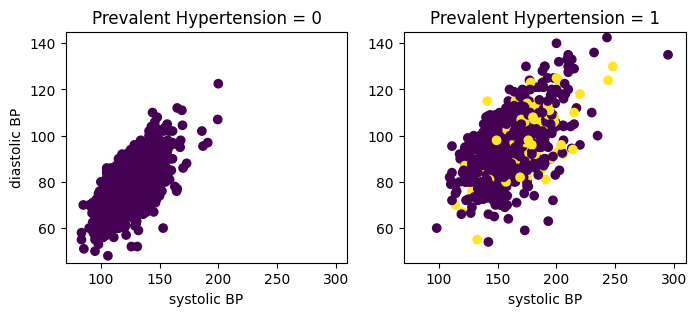

In [11]:
fig,axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(data.sysBP[data.prevalentHyp==0],data.diaBP[data.prevalentHyp==0],c=data.BPMeds[data.prevalentHyp==0])
axs[0].set_xlim(70,310)
axs[0].set_ylim(45,145)
axs[0].set_title("Prevalent Hypertension = 0")
axs[0].set_xlabel("systolic BP")
axs[0].set_ylabel("diastolic BP")

axs[1].scatter(data.sysBP[data.prevalentHyp==1],data.diaBP[data.prevalentHyp==1],c=data.BPMeds[data.prevalentHyp==1])
axs[1].set_xlim(70,310)
axs[1].set_ylim(45,145)
axs[1].set_title("Prevalent Hypertension = 1")
axs[1].set_xlabel("systolic BP")

In [12]:
#Dropping the rows that have null values in BP meds columns (53 rows will be dropped)

data = data[data.BPMeds.notnull()]

***GLUCOSE LEVEL***

		Mean glucose=79				Mean glucose=171
		Median glucose=78			Median glucose=147


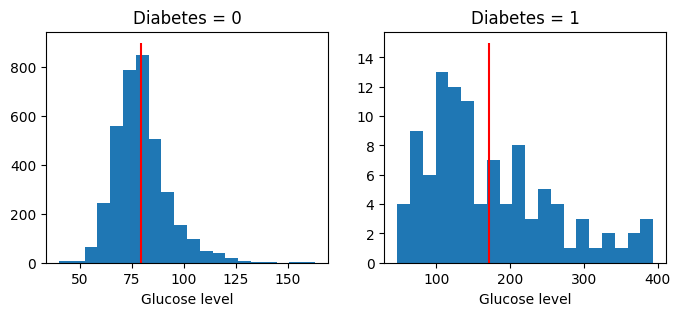

In [13]:
gluc_mu = [data.glucose[data.diabetes==0].mean(),data.glucose[data.diabetes==1].mean()]
gluc_med = [data.glucose[data.diabetes==0].median(),data.glucose[data.diabetes==1].median()]
print(f"\t\tMean glucose={gluc_mu[0]:.0f}",end="\t")
print(f"\t\t\tMean glucose={gluc_mu[1]:.0f}")
print(f"\t\tMedian glucose={gluc_med[0]:.0f}",end="\t")
print(f"\t\tMedian glucose={gluc_med[1]:.0f}")
fig,axs = plt.subplots(1,2,figsize=(8,3))
axs[0].hist(data.glucose[data.diabetes==0],density=False,bins=20)
axs[0].set_title("Diabetes = 0")
axs[0].set_xlabel("Glucose level")
axs[0].vlines(gluc_mu[0],0,900,colors="red")

axs[1].hist(data.glucose[data.diabetes==1],density=False, bins=20)
axs[1].set_title("Diabetes = 1")
axs[1].set_xlabel("Glucose level")
axs[1].vlines(gluc_mu[1],0,15,colors="red")

plt.show()

In [14]:
idx = data[data.glucose.isnull()].index
temp = data.loc[idx,["glucose","diabetes"]]
print("Null data split by diabetes group")
temp.groupby(by=data.diabetes).count()

Null data split by diabetes group


,glucose,diabetes
diabetes,,
0,0,382
1,0,4


In [15]:
#Imputing the null values with median

data.loc[(data.glucose.isnull())&(data.diabetes==1),["glucose"]] = gluc_med[1]
data.loc[(data.glucose.isnull())&(data.diabetes==0),["glucose"]] = gluc_med[0]

In [16]:
temp = data.loc[idx,["glucose","diabetes"]]
print("data split by diabetes group")
temp.groupby(by=data.diabetes).median()

data split by diabetes group


,glucose,diabetes
diabetes,,
0,78.0,0.0
1,147.0,1.0


***BMI***

In [17]:
dk = data[data.prevalentHyp==0]
bmi_group0 = [0 if dk.BMI.iloc[i] <= 18.5 else 1 if 18.5<=dk.BMI.iloc[i] <=24.9 else 2 if 25.0<= dk.BMI.iloc[i]<=29.9 else 3 for i in range(len(dk))]
dj = data[data.prevalentHyp==1]
bmi_group1 = [0 if dj.BMI.iloc[i] <= 18.5 else 1 if 18.5<=dj.BMI.iloc[i] <=24.9 else 2 if 25.0<= dj.BMI.iloc[i]<=29.9 else 3 for i in range(len(dj))]

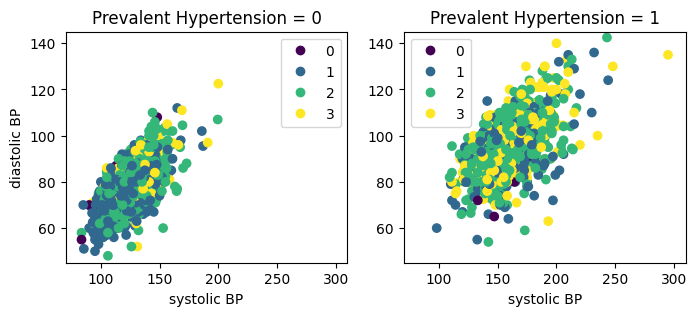

In [18]:
fig,axs = plt.subplots(1,2,figsize=(8,3))
sc0 = axs[0].scatter(data.sysBP[data.prevalentHyp==0],data.diaBP[data.prevalentHyp==0],c=bmi_group0)
axs[0].set_xlim(70,310)
axs[0].set_ylim(45,145)
axs[0].set_title("Prevalent Hypertension = 0")
axs[0].set_xlabel("systolic BP")
axs[0].set_ylabel("diastolic BP")

axs[0].legend(*sc0.legend_elements())

sc1 = axs[1].scatter(data.sysBP[data.prevalentHyp==1],data.diaBP[data.prevalentHyp==1],c=bmi_group1)
axs[1].set_xlim(70,310)
axs[1].set_ylim(45,145)
axs[1].set_title("Prevalent Hypertension = 1")
axs[1].set_xlabel("systolic BP")

axs[1].legend(*sc1.legend_elements())

plt.show()

	Mean BMI :25				Mean BMI :28


Text(0.5, 1.0, 'Prevalent Hypertension=1')

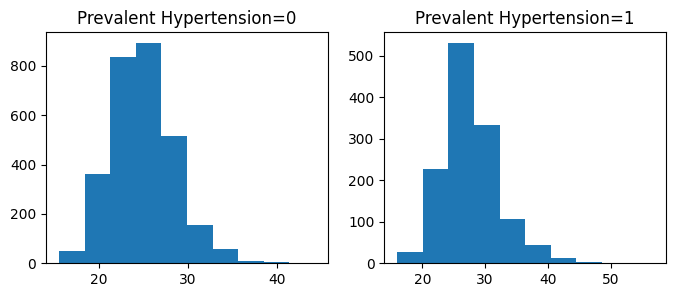

In [19]:
bmi_mu = [data[data.prevalentHyp==0].BMI.mean(),data[data.prevalentHyp==1].BMI.mean()]
print(f"\tMean BMI :{bmi_mu[0]:.0f}",end="\t")
print(f"\t\t\tMean BMI :{bmi_mu[1]:.0f}")

fig,axs = plt.subplots(1,2,figsize=(8,3))
axs[0].hist(data[data.prevalentHyp==0].BMI)
axs[0].set_title("Prevalent Hypertension=0")

axs[1].hist(data[data.prevalentHyp==1].BMI)
axs[1].set_title("Prevalent Hypertension=1")


In [20]:
#Imputing the null values with Mean BMI

data.loc[(data.BMI.isnull())&(data.prevalentHyp==0),["BMI"]] = bmi_mu[0]
data.loc[(data.BMI.isnull())&(data.prevalentHyp==1),["BMI"]] = bmi_mu[1]

***TOTAL CHOLESTROL***

	Mean Cholestrol level :232				Mean Cholestrol level :247


Text(0.5, 1.0, 'Prevalent Hypertension=1')

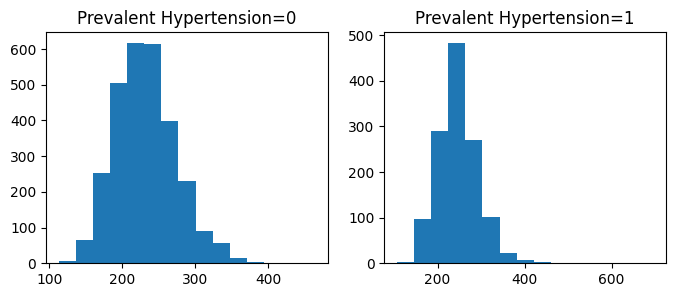

In [21]:
chol_mu = [data[data.prevalentHyp==0].totChol.mean(),data[data.prevalentHyp==1].totChol.mean()]
print(f"\tMean Cholestrol level :{chol_mu[0]:.0f}",end="\t")
print(f"\t\t\tMean Cholestrol level :{chol_mu[1]:.0f}")

fig,axs = plt.subplots(1,2,figsize=(8,3))
axs[0].hist(data[data.prevalentHyp==0].totChol,bins=15)
axs[0].set_title("Prevalent Hypertension=0")

axs[1].hist(data[data.prevalentHyp==1].totChol,bins=15)
axs[1].set_title("Prevalent Hypertension=1")


In [22]:
data.loc[:,"age_group"] = data.age.apply(lambda s: "30 to 40" if 30<=s<=40 else "40 to 50" if 40<=s<=50 else "50 to 60" if 50<=s<=60 else "60 to 70" if 60<=s<=70 else "Above 70")

In [23]:
age_series = data.totChol.groupby(by=data.age_group).median()
age_series

age_group
30 to 40    210.0
40 to 50    230.0
50 to 60    245.0
60 to 70    245.0
Name: totChol, dtype: float64

In [24]:
#Imputing the cholestroll null values based on age group

data.loc[data.totChol.isnull(),["totChol"]] = data.loc[data.totChol.isnull(),"age_group"].apply(lambda c: age_series[c])

In [25]:
data = data.iloc[:,0:-1]

***HEART RATE***

In [26]:
data = data[data.heartRate.notnull()]

In [27]:
data.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay           0
BPMeds               0
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              0
sysBP                0
diaBP                0
BMI                  0
heartRate            0
glucose              0
TenYearCHD           0
dtype: int64

### TRAIN AND TEST SPLIT

In [28]:
y = data.TenYearCHD
x = data.drop(["education","TenYearCHD"],axis=1)

train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.2)

In [29]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(3347, 14)
(3347,)
(837, 14)
(837,)


### FEATURE SCALING

In [30]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

In [31]:
train_y = np.array(train_y) 
test_y = np.array(test_y) 

### LOGISTIC REGRESION USING GRADIENT DESCENT

$$
\begin{align}
  f_{\mathbf{w},b}(\mathbf{x^{(i)}}) &= g(z^{(i)})\tag{3} \\
  z^{(i)} &= \mathbf{w} \cdot \mathbf{x}^{(i)}+ b\tag{4} \\
  g(z^{(i)}) &= \frac{1}{1+e^{-z^{(i)}}}\tag{5} 
\end{align}
$$

In [32]:
def sigmoid(z):
    g_z = 1/(1+np.exp(-z))
    return g_z

## Logistic Gradient Descent

Gradient descent algorithm utilizes the gradient calculation:
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

Where each iteration performs simultaneous updates on $w_j$ for all $j$, where
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}$$

In [33]:
def compute_gradient_logistic(x,y,w,b):
    
    # x: (m,n)
    # y: (m,)
    # w: (n,)
    
    m,n = x.shape 
    #m: number of data points
    #n: number of features
        
    dw = np.zeros((n,)) #derivative with respect to each data point 
    db = 0
    for i in range(m): #for each data point
        zi = np.dot(x[i,:],w)+b 
        f_xi = sigmoid(zi) #calculate probability
        err_i = (f_xi - y[i])
        db = db + err_i 

        for j in range(n):
            dw[j,] =  dw[j,] + err_i * x[i,j]
    
    dJ_w = dw/m
    dJ_b = db/m
    
    return dJ_b, dJ_w

In [34]:
X_tmp = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_tmp = np.array([0, 0, 0, 1, 1, 1])
w_tmp = np.array([2.,3.])
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic(X_tmp, y_tmp, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}" )
print(f"dj_dw: {dj_dw_tmp.tolist()}" )

dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]


**Expected output**
``` 
dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]
```

In [35]:
w_tmp = np.zeros(train_x.shape[1])
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic(train_x_scaled, train_y, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}" )
print(f"dj_dw: {dj_dw_tmp.tolist()}" )

dj_db: 0.5771894420897902
dj_dw: [-0.03352715733409372, -0.08299985265555111, -0.0056327795731325415, -0.01842290275491874, -0.03309544433296917, -0.02416484820249621, -0.0633480689365751, -0.034524702629505966, -0.02704510862551829, -0.07748030458550505, -0.05176269346790139, -0.02707566451957844, -0.00831253874617692, -0.04304192822422862]


## Cost function

For logistic regression, the cost function is of the form 

$$ J(\mathbf{w},b) = \frac{1}{m} \sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is:

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
*  where m is the number of training examples in the data set and:

In [36]:
def compute_cost_logistic(x,y,w,b):
    
    m = x.shape[0]
    loss = 0
    for i in range(m):
        zi = np.dot(x[i,],w)+b
        f_xi = sigmoid(zi)      
        loss += (y[i] * np.log(f_xi))  +  ((1-y[i]) * np.log(1-f_xi))
        
    cost = -(1/m)*loss
    
    return cost

In [37]:
X_tr = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])  #(m,n)
y_tr = np.array([0, 0, 0, 1, 1, 1])                                           #(m,)
w_tmp = np.array([1,1])
b_tmp = -3
print(compute_cost_logistic(X_tr, y_tr, w_tmp, b_tmp))

0.3668667864055174


**Expected output**: 0.3668667864055175

In [38]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters):
    
    J = []
    
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        dJ_b, dJ_w = compute_gradient_logistic(x,y,w,b)
        w = w - alpha * dJ_w
        b = b - alpha * dJ_b

        if i % math.ceil(num_iters / 10) == 0:
            cost = compute_cost_logistic(x,y,w,b)
            print(f"Iteration: {i} Cost: {cost}") 
            J = np.append(J,cost)
    
    cost = compute_cost_logistic(x,y,w,b)         
    J = np.append(J,cost)
            
    return w,b,J

In [39]:
w_tmp  = np.zeros(train_x.shape[1])
b_tmp  = 0.
alph = 0.1
iters = 10000

w_out, b_out, _ = gradient_descent(train_x_scaled, train_y, w_tmp, b_tmp, alph, iters) 

Iteration: 0 Cost: 0.6786738899929791
Iteration: 1000 Cost: 0.3814079007037733
Iteration: 2000 Cost: 0.38140397367285445
Iteration: 3000 Cost: 0.3814039486677842
Iteration: 4000 Cost: 0.3814039484951363
Iteration: 5000 Cost: 0.38140394849389003
Iteration: 6000 Cost: 0.38140394849388215
Iteration: 7000 Cost: 0.3814039484938819
Iteration: 8000 Cost: 0.38140394849388115
Iteration: 9000 Cost: 0.38140394849388215


In [40]:
print("w from gradient descent: ",w_out)
print("b from gradient descent: ",b_out)

w from gradient descent:  [ 0.25803847  0.54665572  0.00447369  0.24639885  0.05254608  0.08389798
  0.10480186  0.03237646  0.05127127  0.32302316 -0.06071392  0.01138815
 -0.02016167  0.14333076]
b from gradient descent:  -1.956777700707389


*Comparison*   
Solution from scikit logistic model

W: [[ 0.23628162  0.5790852   0.09208339  0.20734428  0.06365865  0.07116424
   0.05897178 -0.0259253   0.03761975  0.28268684  0.04520515 -0.01132371
  -0.01412088  0.19872628]]   
b: [-1.9958399]

In [41]:
def predict(w,b,x):
    f_x = np.dot(x,w)+b
    y_pred = np.zeros(len(x))
    for i in range(len(f_x)):
        if f_x[i] >= 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    return y_pred

In [42]:
y_pred = predict(w_out,b_out,test_x_scaled)
test_err = np.sum((test_y>0.0) != (y_pred>0.0))
print("Test error: ",test_err/len(test_x))

Test error:  0.13620071684587814


*Comparison*   
Scikit logistic model
Test error:  0.14575866188769415

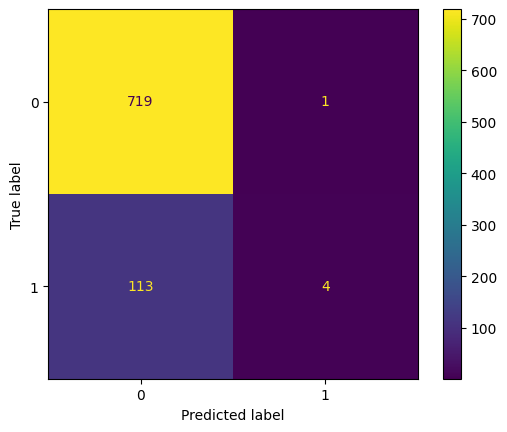

In [43]:
ConfusionMatrixDisplay.from_predictions(test_y,y_pred)

In [44]:
print(f"Model accuracy: {(709+5)/len(test_x_scaled)*100:.1f}%")

Model accuracy: 85.3%


In [45]:
cost = compute_cost_logistic(test_x_scaled,test_y,w_out,b_out) 
print("Cost:", cost)

Cost: 0.3648736156538748


*Comparison*     
Scikit Logistiic model cost:  0.39274319